In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import mode
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    log_loss, roc_auc_score, roc_curve, precision_recall_curve,
    cohen_kappa_score, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

### Importing the data, preprocessing it, and splitting into train and test

In [ ]:
bean_data = pd.read_csv('Dry_Bean_Dataset.csv')

X=bean_data.drop(columns=['Class'])

min_max = MinMaxScaler(feature_range=(-1, 1))
X_scaled = min_max.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled

y = bean_data.Class
# Encode labels if they are categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

#confirming proportions are the same after the strat split
print('Proportions: \n', pd.DataFrame(y_train).value_counts(normalize=True))
print(pd.DataFrame(y_test).value_counts(normalize=True))

Proportions: 
 0
3    0.260562
6    0.193699
5    0.148880
4    0.141624
2    0.119765
0    0.097079
1    0.038391
Name: proportion, dtype: float64
0
3    0.260375
6    0.193537
5    0.149100
4    0.141755
2    0.119721
0    0.097319
1    0.038193
Name: proportion, dtype: float64


### Forming the individual models

##### NN with some parameter tuning

In [36]:
# Define the model-building function
def build_model(hp):
    model_NN = Sequential()
    # Input layer and first hidden layer
    model_NN.add(Dense(
        units=hp.Int('units_layer1', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=(16,)
    ))
    model_NN.add(Dropout(hp.Float('dropout_layer1', min_value=0.2, max_value=0.5, step=0.1)))

    # Second hidden layer
    model_NN.add(Dense(
        units=hp.Int('units_layer2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model_NN.add(Dropout(hp.Float('dropout_layer2', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model_NN.add(Dense(len(np.unique(y)), activation='softmax'))

    # Compile the model_NN
    model_NN.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model_NN

# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of models to try
    directory='my_dir',
    project_name='tune_tabular_model'
)

# Run the tuner
tuner.search(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Train the best model
best_model_NN = tuner.hypermodel.build(best_hps)
history = best_model_NN.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)


Reloading Tuner from my_dir\tune_tabular_model\tuner0.json
Best Hyperparameters: {'units_layer1': 192, 'dropout_layer1': 0.30000000000000004, 'units_layer2': 64, 'dropout_layer2': 0.30000000000000004, 'learning_rate': 0.001}
Epoch 1/50
273/273 [==============================] - 2s 4ms/step - loss: 0.7578 - accuracy: 0.7254 - val_loss: 0.3037 - val_accuracy: 0.8930
Epoch 2/50
273/273 [==============================] - 1s 3ms/step - loss: 0.3603 - accuracy: 0.8718 - val_loss: 0.2433 - val_accuracy: 0.9137
Epoch 3/50
273/273 [==============================] - 1s 3ms/step - loss: 0.3008 - accuracy: 0.8962 - val_loss: 0.2304 - val_accuracy: 0.9178
Epoch 4/50
273/273 [==============================] - 1s 3ms/step - loss: 0.2885 - accuracy: 0.8979 - val_loss: 0.2317 - val_accuracy: 0.9164
Epoch 5/50
273/273 [==============================] - 1s 3ms/step - loss: 0.2744 - accuracy: 0.9055 - val_loss: 0.2250 - val_accuracy: 0.9183
Epoch 6/50
273/273 [==============================] - 1s 3ms/step

In [37]:
# predictions
y_proba_NN = best_model_NN.predict(X_test)
y_pred_NN = np.argmax(y_proba_NN, axis=1)
print(classification_report(y_test, y_pred_NN, target_names=label_encoder.classes_))


86/86 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.89      0.91       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.92      0.94      0.93       326
    DERMASON       0.91      0.91      0.91       709
       HOROZ       0.95      0.96      0.96       386
       SEKER       0.92      0.96      0.94       406
        SIRA       0.87      0.84      0.86       527

    accuracy                           0.92      2723
   macro avg       0.93      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



#### Random Forest

In [31]:
model_RF = RandomForestClassifier(
random_state=42)
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_RF)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RF, target_names=label_encoder.classes_))

Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.89      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.94      0.94      0.94       326
    DERMASON       0.90      0.92      0.91       709
       HOROZ       0.97      0.95      0.96       386
       SEKER       0.94      0.96      0.95       406
        SIRA       0.86      0.86      0.86       527

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



#### XGBoost

In [29]:
# Step 2: Create and train the XGBoost model
model_XGB = XGBClassifier(
    objective='multi:softmax',  # for multiclass classification
    num_class=len(np.unique(y))  # number of classes
)
model_XGB.fit(X_train, y_train)
# Step 3: Make predictions on the test set
y_pred_XGB = model_XGB.predict(X_test)
# Step 4: Evaluate the model_XGB
accuracy = accuracy_score(y_test, y_pred_XGB)
print(f"Accuracy: {accuracy:.2f}")
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_XGB, target_names=label_encoder.classes_))

Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.90      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.94      0.94      0.94       326
    DERMASON       0.90      0.93      0.92       709
       HOROZ       0.96      0.96      0.96       386
       SEKER       0.96      0.96      0.96       406
        SIRA       0.88      0.87      0.87       527

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



#### SVM

In [38]:
model_SVM = SVC(
kernel='rbf',
C=1.0,
gamma='scale',
probability=True,
random_state=42)
model_SVM.fit(X_train, y_train)
y_pred_SVM = model_SVM.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_SVM)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_SVM, target_names=label_encoder.classes_))

Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.96      0.86      0.91       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.92      0.94      0.93       326
    DERMASON       0.92      0.91      0.92       709
       HOROZ       0.97      0.95      0.96       386
       SEKER       0.94      0.95      0.94       406
        SIRA       0.85      0.89      0.87       527

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



### Forming Enesemble

#### Simple majority

In [78]:
# Combine predictions using majority voting
ensemble_predictions_majority = mode([y_pred_NN, y_pred_RF, y_pred_XGB, y_pred_SVM], axis=0)[0].ravel()

# Calculate accuracy
accuracy = accuracy_score(y_test, ensemble_predictions_majority)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report (Majority Ensemble):")
print(classification_report(y_test, ensemble_predictions_majority, target_names=label_encoder.classes_))


Ensemble Model Accuracy: 0.9243

Classification Report (Majority Ensemble):
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.90      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.93      0.94      0.94       326
    DERMASON       0.91      0.93      0.92       709
       HOROZ       0.96      0.96      0.96       386
       SEKER       0.94      0.96      0.95       406
        SIRA       0.88      0.85      0.87       527

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.94      2723
weighted avg       0.92      0.92      0.92      2723



In [75]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions_majority)

# Calculate accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print accuracy for each class
print("\nAccuracy for Each Class:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {class_accuracies[i]:.4f}")



Accuracy for Each Class:
BARBUNYA: 0.9019
BOMBAY: 1.0000
CALI: 0.9387
DERMASON: 0.9337
HOROZ: 0.9560
SEKER: 0.9581
SIRA: 0.8501


#### Using combined probabilities

In [77]:
y_proba_NN = best_model_NN.predict(X_test)
y_proba_RF = model_RF.predict_proba(X_test)
y_proba_XGB = model_XGB.predict_proba(X_test)
y_proba_SVM = model_SVM.predict_proba(X_test)

# Combine probabilities by multiplying probabilities
ensemble_probs = (y_proba_NN * y_proba_RF * y_proba_XGB * y_proba_SVM) / 4
# Get the class with the highest average probability
ensemble_predictions = np.argmax(ensemble_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report (Probability Ensemble):")
print(classification_report(y_test, ensemble_predictions, target_names=label_encoder.classes_))

86/86 [==============================] - 0s 2ms/step
Ensemble Model Accuracy: 0.9251

Classification Report (Probability Ensemble):
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.90      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.94      0.94      0.94       326
    DERMASON       0.91      0.92      0.92       709
       HOROZ       0.96      0.96      0.96       386
       SEKER       0.93      0.96      0.95       406
        SIRA       0.87      0.87      0.87       527

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.92      2723



In [61]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions)

# Calculate accuracy for each class
class_accuracies_CP = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print accuracy for each class
print("\nAccuracy for Each Class:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {class_accuracies_CP[i]:.4f}")


Accuracy for Each Class:
BARBUNYA: 0.8981
BOMBAY: 1.0000
CALI: 0.9448
DERMASON: 0.9224
HOROZ: 0.9611
SEKER: 0.9557
SIRA: 0.8653


### Simple visualizations

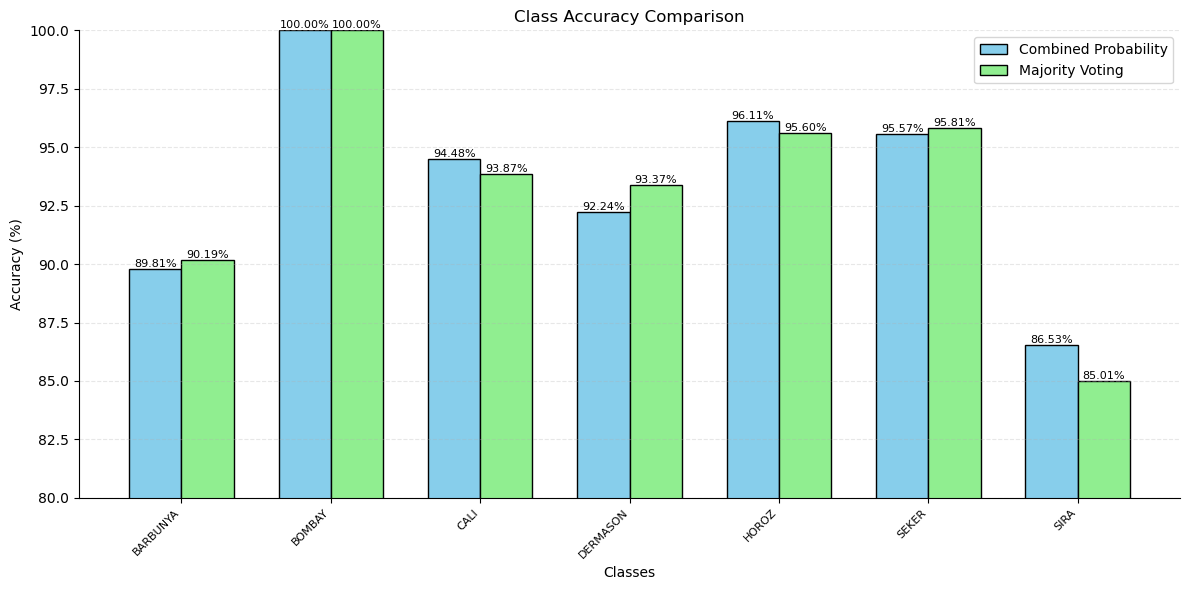

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have calculated accuracies for each class
classes = ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
accuracies_CP = 100 * class_accuracies_CP  # First set of accuracies
accuracies_MV = 100 * class_accuracies  # Second set of accuracies

fig, ax = plt.subplots(figsize=(12, 6))  # Slightly wider to accommodate both sets

# Create grouped bars
bar_width = 0.35
r1 = np.arange(len(classes))
r2 = [x + bar_width for x in r1]

bars1 = ax.bar(r1, accuracies_CP, color='skyblue', width=bar_width, edgecolor='black', linewidth=1, label='Combined Probability')
bars2 = ax.bar(r2, accuracies_MV, color='lightgreen', width=bar_width, edgecolor='black', linewidth=1, label='Majority Voting')

# Customize the appearance
ax.set_ylabel('Accuracy (%)', fontsize=10)
ax.set_xlabel('Classes', fontsize=10)
ax.set_title('Class Accuracy Comparison', fontsize=12)
ax.set_xticks([r + bar_width/2 for r in range(len(classes))])
ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=8)

# Add value labels on top of each bar with percent sign
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

add_labels(bars1)
add_labels(bars2)

# Set y-axis limit to range from 80 to 100
ax.set_ylim(80, 100)

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

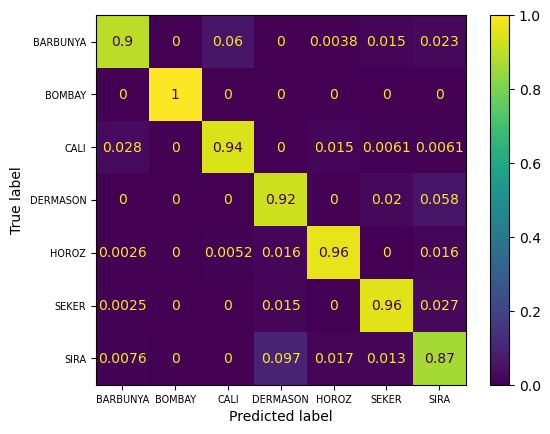

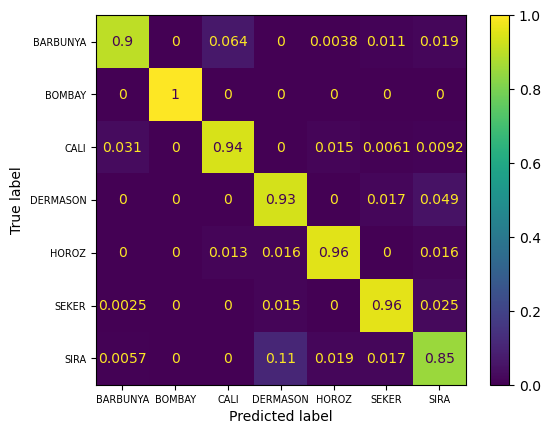

In [76]:
conf_mx = confusion_matrix(y_test, ensemble_predictions)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
disp = ConfusionMatrixDisplay(confusion_matrix=norm_conf_mx,
                              display_labels=label_encoder.classes_)
disp.plot()
#np.fill_diagonal(norm_conf_mx, 0)
#plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.tick_params(axis='both', labelsize=7)
plt.show()


conf_mx = confusion_matrix(y_test, ensemble_predictions_majority)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
disp = ConfusionMatrixDisplay(confusion_matrix=norm_conf_mx,
                              display_labels=label_encoder.classes_)
disp.plot()
#np.fill_diagonal(norm_conf_mx, 0)
#plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.tick_params(axis='both', labelsize=7)
plt.show()